Importing the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wasif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Wasif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wasif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wasif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Wasif\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading the two datasets and merging them into one.

In [2]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

df_fake['label'] = 1
df_true['label'] = 0

df = pd.concat([df_fake, df_true], axis=0)

df = df.sample(frac=1).reset_index(drop=True)

print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Class Distribution ---")
print(df['label'].value_counts())


--- First 5 Rows ---
                                               title  \
0  WARNING: Don’t Worry If the Stock Market Goes ...   
1   EXPLOSIVE REPORT: Fmr. NSA Analyst Reveals Te...   
2  Protests planned for Trump speech at pro-Israe...   
3  U.S. top court's Gorsuch says does not share '...   
4   John Boehner Has A New Job, And It’s Vile (VI...   

                                                text       subject  \
0   BloombergIn the hours after the president is ...       US_News   
1  We all know how hostile the Trump White House ...          News   
2  NEW YORK (Reuters) - Some rabbis and Jewish st...  politicsNews   
3  CAMBRIDGE, Mass. (Reuters) - President Donald ...  politicsNews   
4  When John Boehner left Congress, he left behin...          News   

                 date  label  
0    November 7, 2016      1  
1       March 7, 2017      1  
2     March 17, 2016       0  
3       June 3, 2017       0  
4  September 17, 2016      1  

--- Dataset Info ---
<class 'pand

Dropping the rows with either blank title or blank text cells.

In [3]:
df.dropna(subset=['title', 'text'], inplace=True)

df.reset_index(drop=True, inplace=True)

print(df.head())
print(df.info())

                                               title  \
0  WARNING: Don’t Worry If the Stock Market Goes ...   
1   EXPLOSIVE REPORT: Fmr. NSA Analyst Reveals Te...   
2  Protests planned for Trump speech at pro-Israe...   
3  U.S. top court's Gorsuch says does not share '...   
4   John Boehner Has A New Job, And It’s Vile (VI...   

                                                text       subject  \
0   BloombergIn the hours after the president is ...       US_News   
1  We all know how hostile the Trump White House ...          News   
2  NEW YORK (Reuters) - Some rabbis and Jewish st...  politicsNews   
3  CAMBRIDGE, Mass. (Reuters) - President Donald ...  politicsNews   
4  When John Boehner left Congress, he left behin...          News   

                 date  label  
0    November 7, 2016      1  
1       March 7, 2017      1  
2     March 17, 2016       0  
3       June 3, 2017       0  
4  September 17, 2016      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 

Removing publisher name from the beginning of the "text".

In [ ]:
def remove_reuters_header(text):
    pattern = r"^.*?\(Reuters\)\s*-\s*"
    return re.sub(pattern, "", text)

df['text'] = df['text'].apply(remove_reuters_header)
print(df.head())

                                               title  \
0  WARNING: Don’t Worry If the Stock Market Goes ...   
1   EXPLOSIVE REPORT: Fmr. NSA Analyst Reveals Te...   
2  Protests planned for Trump speech at pro-Israe...   
3  U.S. top court's Gorsuch says does not share '...   
4   John Boehner Has A New Job, And It’s Vile (VI...   

                                                text       subject  \
0   BloombergIn the hours after the president is ...       US_News   
1  We all know how hostile the Trump White House ...          News   
2  Some rabbis and Jewish students are planning p...  politicsNews   
3  President Donald Trump’s U.S. Supreme Court ap...  politicsNews   
4  When John Boehner left Congress, he left behin...          News   

                 date  label  
0    November 7, 2016      1  
1       March 7, 2017      1  
2     March 17, 2016       0  
3       June 3, 2017       0  
4  September 17, 2016      1  


Merging the title and text columns into the new "content" column, and then dropping the title and text columns along with date and subject.

In [5]:
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

df['content'] = df['title'] + " " + df['text']

df = df.drop(['title', 'text', 'date', 'subject'], axis=1)

print(df.head())
print(df.info())

   label                                            content
0      1  WARNING: Don’t Worry If the Stock Market Goes ...
1      1   EXPLOSIVE REPORT: Fmr. NSA Analyst Reveals Te...
2      0  Protests planned for Trump speech at pro-Israe...
3      0  U.S. top court's Gorsuch says does not share '...
4      1   John Boehner Has A New Job, And It’s Vile (VI...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    44898 non-null  int64 
 1   content  44898 non-null  object
dtypes: int64(1), object(1)
memory usage: 701.7+ KB
None


Cleaner and lemmatizer.

In [8]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(filtered_tokens)

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(lemmatized_words)

Cleaning up the new "content" column.

In [9]:
df['content'] = df['content'].apply(clean_text)
df['content'] = df['content'].apply(lemmatize_text)

print("Cleaning complete!")
print(df['content'].head())

Cleaning complete!
0    warning ’ worry stock market go crazy election...
1    explosive report fmr nsa analyst reveals team ...
2    protest planned trump speech proisrael confere...
3    u top court gorsuch say share cynicism governm...
4    john boehner new job ’ vile video john boehner...
Name: content, dtype: object


Splitting and vectorizing.

In [ ]:
X = df['content']
y = df['label']

print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=50000
)

print("Vectorizing data... ")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Vectorization complete!")
print(f"Training Data Shape: {X_train_tfidf.shape}")
print(f"Testing Data Shape: {X_test_tfidf.shape}")

Splitting data into training and testing sets...
Vectorizing data... 
Vectorization complete!
Training Data Shape: (35918, 50000)
Testing Data Shape: (8980, 50000)


Training Logistic Regression, LinearSVC, Decision Tree, Random Forest, Gradient Boosting, Passive Aggressive Classifier, and Hard Voting.

Training models with detailed metrics...
------------------------------------------------------------
Done: Logistic Regression
Done: Linear SVC
Done: Decision Tree
Done: Random Forest
Done: Gradient Boosting
Done: Passive Aggressive
------------------------------------------------------------
Training Voting Classifier...

Final Leaderboard (Sorted by F1-Score):
                 Model  Accuracy  Precision    Recall  F1-Score
5   Passive Aggressive  0.991759   0.991763  0.991759  0.991760
1           Linear SVC  0.991425   0.991436  0.991425  0.991426
6    Voting Classifier  0.991425   0.991432  0.991425  0.991426
3        Random Forest  0.985746   0.985761  0.985746  0.985748
0  Logistic Regression  0.984076   0.984123  0.984076  0.984079
4    Gradient Boosting  0.964922   0.965111  0.964922  0.964934
2        Decision Tree  0.956904   0.956972  0.956904  0.956888


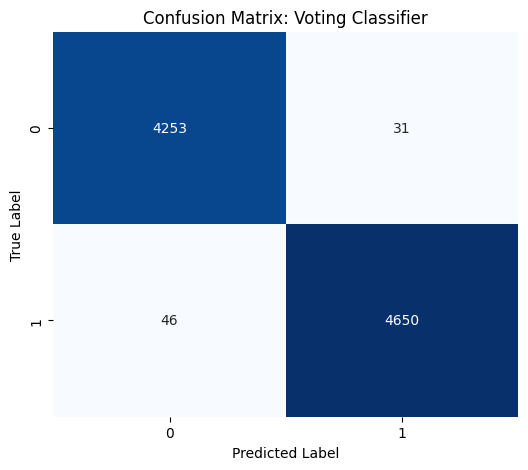

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVC": LinearSVC(dual="auto", max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000)
}

results = []

print("Training models with detailed metrics...")
print("-" * 60)

# Train Loop
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results.append({
        "Model": name, 
        "Accuracy": acc, 
        "Precision": precision, 
        "Recall": recall, 
        "F1-Score": f1
    })
    
    print(f"Done: {name}")

# Voting Classifier
print("-" * 60)
print("Training Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[('lr', models["Logistic Regression"]), ('svc', models["Linear SVC"]), ('pac', models["Passive Aggressive"])],
    voting='hard'
)
voting_clf.fit(X_train_tfidf, y_train)
y_pred_vote = voting_clf.predict(X_test_tfidf)

# Metrics for Voting
acc = accuracy_score(y_test, y_pred_vote)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_vote, average='weighted')
results.append({"Model": "Voting Classifier", "Accuracy": acc, "Precision": precision, "Recall": recall, "F1-Score": f1})

results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\nFinal Leaderboard (Sorted by F1-Score):")
print(results_df)

plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred_vote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Generate bar graph comparing the accuracy of the 6 models.

C:\Users\Wasif\AppData\Local\Temp\ipykernel_5524\91187120.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


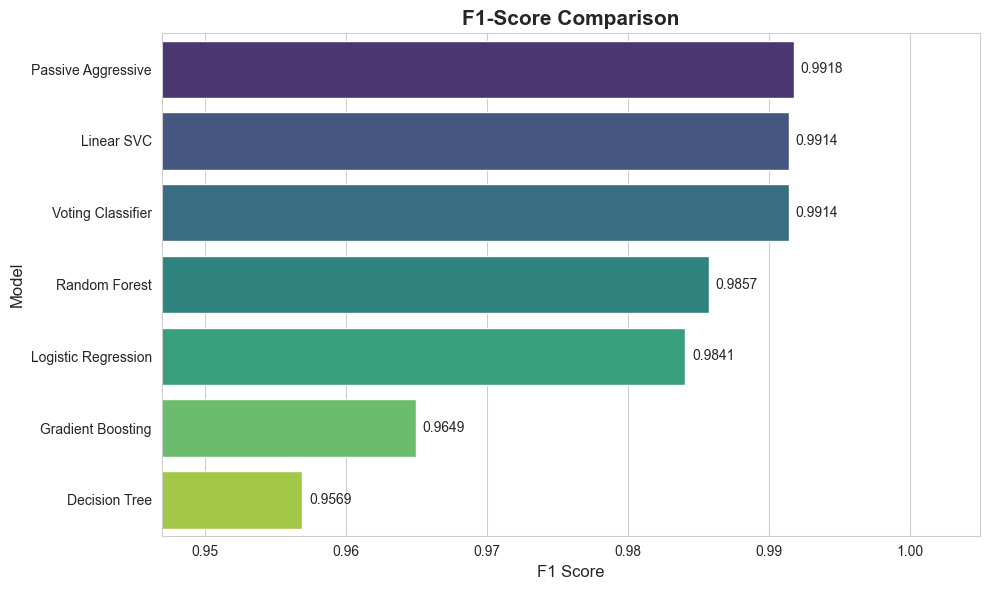

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x='F1-Score', 
    y='Model', 
    data=results_df, 
    palette='viridis'
)

plt.title('F1-Score Comparison', fontsize=15, weight='bold')
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=5, fontsize=10)

min_score = results_df['F1-Score'].min() - 0.01
plt.xlim(min_score, 1.005)

plt.tight_layout()
plt.show()

Tweaking the Hyperparameters of PAC by Grid Search.

In [ ]:
pac_model = PassiveAggressiveClassifier(random_state=42)

param_grid = {
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 1500, 2000],
    'C': [0.001, 0.01, 0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(
    estimator=pac_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=3
)

print("Starting Grid Search for best PAC parameters...")
grid_search.fit(X_train_tfidf, y_train)

print("\nBest Parameters Found:")
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'\nBest F1-score on Test Set: {f1}')

Starting Grid Search for best PAC parameters...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Parameters Found:
{'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000}

Best F1-score on Test Set: 0.9926499486084424


Saving the Optimized Passive Aggressive Classifier.

In [13]:
final_pac_model = grid_search.best_estimator_

joblib.dump(final_pac_model, 'optimized_pac_model_isot.pkl')
joblib.dump(tfidf_vectorizer, 'isot_tfidf_vectorizer.pkl')

print("---")
print("Successfully saved the Optimized PAC Model to: optimized_pac_model_isot.pkl")
print("Successfully saved the TF-IDF Vectorizer to: isot_tfidf_vectorizer.pkl")

---
Successfully saved the Optimized PAC Model to: optimized_pac_model_isot.pkl
Successfully saved the TF-IDF Vectorizer to: isot_tfidf_vectorizer.pkl


Testing the Optimized Passive Aggressive Classifier model on the news.csv dataset.

In [ ]:
final_pac_model = joblib.load('optimized_pac_model_isot.pkl')
tfidf_vectorizer = joblib.load('isot_tfidf_vectorizer.pkl')

new_df = pd.read_csv('news.csv') 

new_df.dropna(subset=['title', 'text'], inplace=True)
new_df.reset_index(drop=True, inplace=True)

y_true_new = new_df['label'].str.lower().replace({'real': 0, 'fake': 1})
y_true_new = y_true_new.dropna()
new_df = new_df.loc[y_true_new.index]

new_df['content'] = new_df['title'].fillna('') + ' ' + new_df['text'].fillna('')

print("Cleaning new data...")
stop_words = set(stopwords.words('english'))
new_df['cleaned_content'] = new_df['content'].apply(clean_text)

print("Vectorizing new data using the SAVED vectorizer...")
X_new_tfidf = tfidf_vectorizer.transform(new_df['cleaned_content'])

print("Predicting labels with Optimized PAC...")
y_pred_new = final_pac_model.predict(X_new_tfidf)

acc = accuracy_score(y_true_new, y_pred_new)
f1 = f1_score(y_true_new, y_pred_new, average='weighted')

print("\n--- RESULTS ON NEW TEST DATA ---")
print(f"Total New Samples: {len(new_df)}")
print(f"Model Accuracy on Separate Dataset: {round(acc*100, 2)}%")
print(f"Model F1-Score on Separate Dataset: {f1}")

C:\Users\Wasif\AppData\Local\Temp\ipykernel_6292\774606052.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true_new = new_df['label'].str.lower().replace({'real': 0, 'fake': 1})


Cleaning new data...
Vectorizing new data using the SAVED vectorizer...
Predicting labels with Optimized PAC...

--- RESULTS ON NEW TEST DATA ---
Total New Samples: 6335
Model Accuracy on Separate Dataset: 60.05%
Model F1-Score on Separate Dataset: 0.5612023921339795


The Optimized Passive Aggressive Classifier model doesn't work well on the news.csv dataset, giving an F1 score of 56.94%.

Generating confusion matrix.

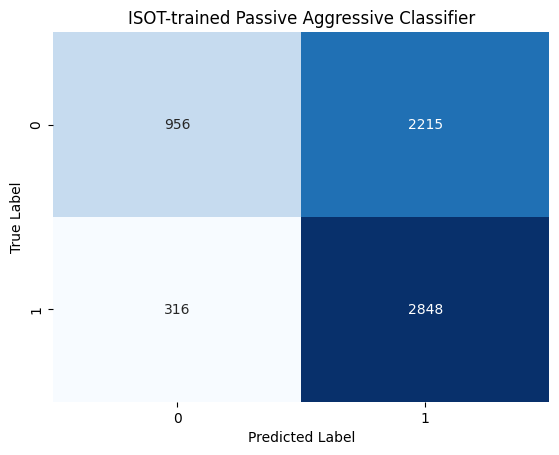

In [15]:
cm = confusion_matrix(y_true_new, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('ISOT-trained Passive Aggressive Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()